# Exercise 5

By using the dataset of Exercise 3 (the one related to the design phase), design an I-MR control chart with probability limits (i.e., use the true distribution of both statistics) with $\alpha=0.01$.

With regard to the MR chart, use both the half-normal distribution and the data transformation.



In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda

# Import the dataset
data = pd.read_csv('ESE06_ex3.csv')

# Inspect the dataset
data.head()

,GM
0,-0.875
1,2.437
2,-1.187
3,-2.063
4,0.938


> ### Solution
> From the solution of Exercise 3, we know that the data are normally distributed and random. 
> Let's find the new value of K for designing the IMR control chart. 

In [2]:
alpha = 0.01
K_alpha = stats.norm.ppf(1-alpha/2)
print('New K value = %.3f' % K_alpha)

New K value = 2.576


> Remove the OOC we observed in Exercise 3.

In [3]:
OOC_idx = 28
data['GM'].iloc[OOC_idx] = np.nan

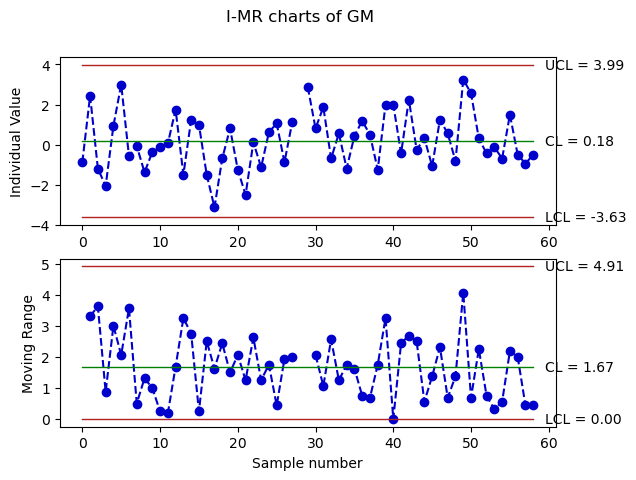

In [4]:
# Design the IMR control chart
data_IMR = qda.ControlCharts.IMR(data, 'GM', K = K_alpha)

> Let's redesign the MR control chart by using the half-normal approximation first:
> - $UCL = D_{1-\alpha/2} \frac{\bar{MR}}{d_2}$
> - $LCL = D_{\alpha/2} \frac{\bar{MR}}{d_2}$
>
> For $n=2$ (Alwan, Appendix A):
> - $D_{1-\alpha/2} = \sqrt{2} z_{alpha/4}$
> - $D_{\alpha/2} = \sqrt{2} z_{1/2 - alpha/4}$

In [5]:
D_UCL = np.sqrt(2) * stats.norm.ppf(1-alpha/4)
D_LCL = np.sqrt(2) * stats.norm.ppf(1 - (1/2 - alpha/4))

MR_UCL = D_UCL * data_IMR['MR'].mean()/qda.constants.getd2(2)
MR_LCL = D_LCL * data_IMR['MR'].mean()/qda.constants.getd2(2)

print('MR_UCL = %.4f' % MR_UCL)
print('MR_LCL = %.4f' % MR_LCL)

MR_UCL = 5.8664
MR_LCL = 0.0131


> Let's plot the MR chart with the half-normal approximation.

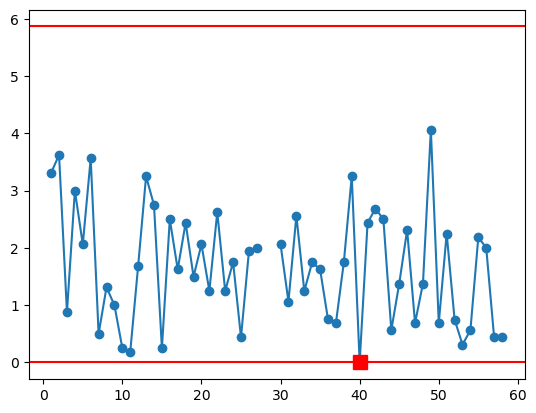

In [6]:
data_IMR['MR_TEST1'] = np.where((data_IMR['MR'] > MR_UCL) | 
                                (data_IMR['MR'] < MR_LCL), data_IMR['MR'], np.nan)

plt.plot(data_IMR['MR'], 'o-')
plt.axhline(MR_UCL, color = 'r')
plt.axhline(MR_LCL, color = 'r')
plt.plot(data_IMR['MR_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

> Now, let's use the normality transformation on the MR data.
> 
> We know we can apply a known transformation ($\lambda = 0.4$).
>
> Attention: Box-Cox is not directly applicable to MR data because we have an observation equal to 0. 

In [7]:
# Extract the 'MR' column   
MR = pd.DataFrame(data_IMR['MR'])
# Get the index of the value equal to 0
idx = MR[MR['MR'] == 0].index[0]
# Change it to NaN
MR['MR'].iloc[idx] = np.nan
# Transform the data
MR['MR'] = MR['MR'].transform(lambda x: ((x**0.4)))
# Replace the NaN value with 0
MR['MR'].iloc[idx] = 0

p-value of the Shapiro-Wilk test: 0.047


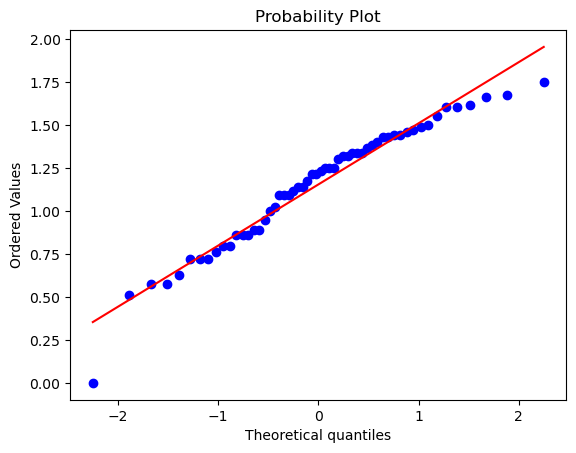

In [8]:
# We can use the Shapiro-Wilk test
data_MR_transformed_dropna = MR.dropna()
_, p_value_SW = stats.shapiro(data_MR_transformed_dropna['MR'])
print('p-value of the Shapiro-Wilk test: %.3f' % p_value_SW)

# QQ-plot
stats.probplot(data_MR_transformed_dropna['MR'], dist="norm", plot=plt)
plt.show()

> Now you can use the I chart on the transformed data.

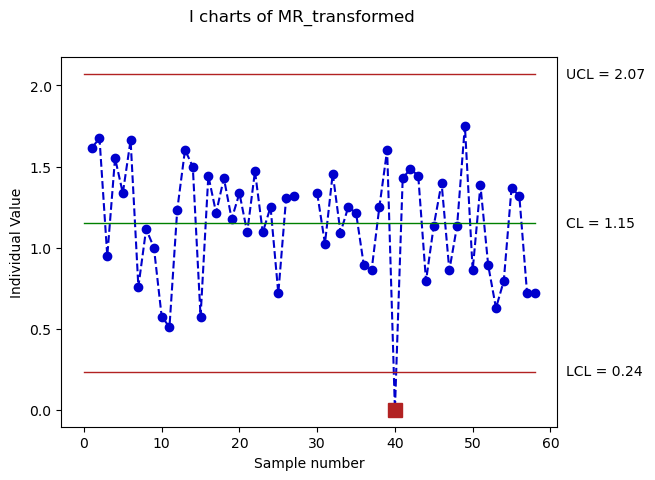

In [9]:
# Change the name of the column in MR to 'MR_transformed'
MR = MR.rename(columns = {'MR': 'MR_transformed'})
data_MR_transformed = qda.ControlCharts.IMR(MR, 'MR_transformed', K = K_alpha, plotit = False)

# Plot the I chart with the transformed data
fig, ax = plt.subplots(1, 1)
fig.suptitle(('I charts of MR_transformed'))
ax.plot(data_MR_transformed['MR_transformed'], color='mediumblue', linestyle='--', marker='o')
ax.plot(data_MR_transformed['I_UCL'], color='firebrick', linewidth=1)
ax.plot(data_MR_transformed['I_CL'], color='g', linewidth=1)
ax.plot(data_MR_transformed['I_LCL'], color='firebrick', linewidth=1)
ax.set_ylabel('Individual Value')
ax.set_xlabel('Sample number')
# add the values of the control limits on the right side of the plot
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_UCL'].iloc[0], 'UCL = {:.2f}'.format(data_MR_transformed['I_UCL'].iloc[0]), verticalalignment='center')
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_CL'].iloc[0], 'CL = {:.2f}'.format(data_MR_transformed['I_CL'].iloc[0]), verticalalignment='center')
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_LCL'].iloc[0], 'LCL = {:.2f}'.format(data_MR_transformed['I_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
ax.plot(data_MR_transformed['I_TEST1'], linestyle='none', marker='s', color='firebrick', markersize=10)
plt.show()
